In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

# We get a lot of warnings about slices of copies, these are not meaningful.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define our source files
COVID_file = 'COVID_by_County/COVID_by_County.csv'
pop_file = 'popData.csv'
US_county_land_file = 'LND01.csv'
US_county_vote_file = 'president_county_candidate.csv'
mask_use_file ="https://raw.githubusercontent.com/nytimes/covid-19-data/master/mask-use/mask-use-by-county.csv"
age_file = "https://raw.githubusercontent.com/ianblackstone/ErdosInstGroupProject/main/median%20age.csv"

# Read the source files into dataframes.
COVID_data = pd.read_csv(COVID_file)
pop_data = pd.read_csv(pop_file)
land_data = pd.read_csv(US_county_land_file)
vote_data = pd.read_csv(US_county_vote_file)
mask_use = pd.read_csv(mask_use_file)
age_data = pd.read_csv(age_file)

In [3]:
# Rename some of the columns
COVID_data = COVID_data.rename(columns={'countyFIPS':'fips'})
pop_data = pop_data.rename(columns={'FIPS':'fips', 'Poverty Percent':'Poverty_pct'})
land_data = land_data.rename(columns={'STCOU':'fips','LND010190D':'land'})

# We don't need most of this dataframe so we truncate it down.
land_data = land_data[['fips','land']]

# the vote data is stored as a mixture of row and column data so we jump through hoops to make it usable.
Biden = vote_data[vote_data.candidate == 'Joe Biden']
Trump = vote_data[vote_data.candidate == 'Donald Trump']
vote_data = Biden[['state', 'county', 'total_votes']].copy()
vote_data.rename(columns={'total_votes':'Biden'}, inplace=True)
vote_data['Trump'] = Trump.total_votes.to_numpy()

# We need some definition that allows us to compare to similar categories.
mask_use['mask_pct'] = mask_use['FREQUENTLY'] + mask_use['ALWAYS']

# merge the vote data into the population data, we can't do this on the main dataframe DF because vote data does not use fips.
pop_data = pd.merge(pop_data, vote_data, left_on = ['CTYNAME', 'STNAME'], right_on = ['county','state'])
pop_data = pd.merge(pop_data, age_data, left_on = 'fips', right_on = 'fips')

In [4]:
# Merge all the datasets into one main dataframe, DF.  Fioltering down when necessary.
DF = pd.merge(COVID_data, pop_data[['fips', 'age', 'POPESTIMATE2018', 'Poverty_pct', 'Biden', 'Trump']], left_on='fips', right_on='fips')
DF = pd.merge(DF,land_data,  left_on='fips', right_on='fips')
DF = pd.merge(DF, mask_use[['COUNTYFP','mask_pct']], left_on = 'fips', right_on = 'COUNTYFP')

# We need to make sure the poverty data is converted from an object type.
#DF.Poverty_pct = DF.Poverty_pct.astype('float')
#This was fixed
print(DF.Poverty_pct.dtype)

# We don't need NaN entries, they will only cause issues.
DF = DF.dropna()

# write out the dataframe to check.
DF

float64


,Dates,fips,County Name,State,cases,deaths,age,POPESTIMATE2018,Poverty_pct,Biden,Trump,land,COUNTYFP,mask_pct
0,1/22/2020,1001,Autauga County,AL,0,0,39.110204,55533,13.8,7503,19838,604.49,1001,0.739
1,1/23/2020,1001,Autauga County,AL,0,0,39.110204,55533,13.8,7503,19838,604.49,1001,0.739
2,1/24/2020,1001,Autauga County,AL,0,0,39.110204,55533,13.8,7503,19838,604.49,1001,0.739
3,1/25/2020,1001,Autauga County,AL,0,0,39.110204,55533,13.8,7503,19838,604.49,1001,0.739
4,1/26/2020,1001,Autauga County,AL,0,0,39.110204,55533,13.8,7503,19838,604.49,1001,0.739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982884,12/5/2020,56045,Weston County,WY,419,2,42.868341,6924,11.8,360,3107,2400.13,56045,0.581
982885,12/6/2020,56045,Weston County,WY,420,2,42.868341,6924,11.8,360,3107,2400.13,56045,0.581
982886,12/7/2020,56045,Weston County,WY,422,2,42.868341,6924,11.8,360,3107,2400.13,56045,0.581
982887,12/8/2020,56045,Weston County,WY,425,2,42.868341,6924,11.8,360,3107,2400.13,56045,0.581


In [5]:
# Need to fix some counties that have 0 area in the dataset, data manually found with Google.
DF.land[DF['County Name'] == 'Broomfield County and City'] = 33.55
DF.land[DF['County Name'] == 'Yakutat City and Borough'] = 9463
DF.land[DF['County Name'] == 'Denali Borough'] = 12777
DF.land[DF['County Name'] == 'Skagway Municipality'] = 464
DF.land[DF['County Name'] == 'Wrangell City and Borough'] = 3477

# We create new columns containing per capita data
DF['cases_per_cap'] = DF.cases / DF.POPESTIMATE2018
DF['deaths_per_cap'] = DF.deaths / DF.POPESTIMATE2018
DF['pop_density'] = DF.POPESTIMATE2018 / DF.land
DF['Biden_per_cap'] = DF.Biden /DF.POPESTIMATE2018
DF['Trump_per_cap'] = DF.Trump /DF.POPESTIMATE2018
DF

,Dates,fips,County Name,State,cases,deaths,age,POPESTIMATE2018,Poverty_pct,Biden,Trump,land,COUNTYFP,mask_pct,cases_per_cap,deaths_per_cap,pop_density,Biden_per_cap,Trump_per_cap
0,1/22/2020,1001,Autauga County,AL,0,0,39.110204,55533,13.8,7503,19838,604.49,1001,0.739,0.000000,0.000000,91.867525,0.135109,0.357229
1,1/23/2020,1001,Autauga County,AL,0,0,39.110204,55533,13.8,7503,19838,604.49,1001,0.739,0.000000,0.000000,91.867525,0.135109,0.357229
2,1/24/2020,1001,Autauga County,AL,0,0,39.110204,55533,13.8,7503,19838,604.49,1001,0.739,0.000000,0.000000,91.867525,0.135109,0.357229
3,1/25/2020,1001,Autauga County,AL,0,0,39.110204,55533,13.8,7503,19838,604.49,1001,0.739,0.000000,0.000000,91.867525,0.135109,0.357229
4,1/26/2020,1001,Autauga County,AL,0,0,39.110204,55533,13.8,7503,19838,604.49,1001,0.739,0.000000,0.000000,91.867525,0.135109,0.357229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982884,12/5/2020,56045,Weston County,WY,419,2,42.868341,6924,11.8,360,3107,2400.13,56045,0.581,0.060514,0.000289,2.884844,0.051993,0.448729
982885,12/6/2020,56045,Weston County,WY,420,2,42.868341,6924,11.8,360,3107,2400.13,56045,0.581,0.060659,0.000289,2.884844,0.051993,0.448729
982886,12/7/2020,56045,Weston County,WY,422,2,42.868341,6924,11.8,360,3107,2400.13,56045,0.581,0.060947,0.000289,2.884844,0.051993,0.448729
982887,12/8/2020,56045,Weston County,WY,425,2,42.868341,6924,11.8,360,3107,2400.13,56045,0.581,0.061381,0.000289,2.884844,0.051993,0.448729


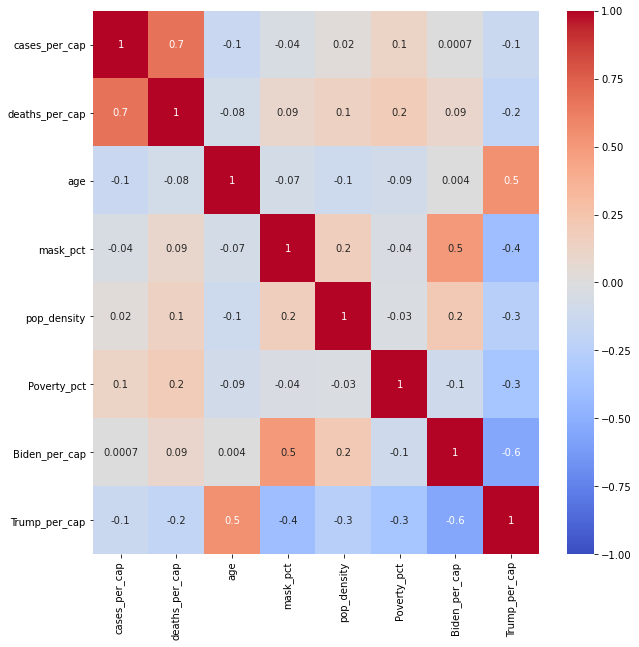

In [6]:
# Print a heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(DF[['cases_per_cap','deaths_per_cap','age','mask_pct','pop_density','Poverty_pct','Biden_per_cap','Trump_per_cap']].corr(), annot = True, fmt = '0.1g', cmap = 'coolwarm', vmin=-1)

In [7]:
# Create some very macabre fits.
deaths_fit = sm.OLS(DF['deaths_per_cap'],sm.add_constant(DF[['Poverty_pct','age','pop_density','mask_pct','Biden_per_cap','Trump_per_cap']])).fit()

print(deaths_fit.summary())

                            OLS Regression Results                            
Dep. Variable:         deaths_per_cap   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                 1.214e+04
Date:                Mon, 14 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:43:42   Log-Likelihood:             6.1882e+06
No. Observations:              982889   AIC:                        -1.238e+07
Df Residuals:                  982882   BIC:                        -1.238e+07
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0001   6.67e-06     20.358

In [8]:
cases_fit = sm.OLS(DF['cases_per_cap'],sm.add_constant(DF[['Poverty_pct','age','pop_density','mask_pct','Biden_per_cap','Trump_per_cap']])).fit()

print(cases_fit.summary())

                            OLS Regression Results                            
Dep. Variable:          cases_per_cap   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     6568.
Date:                Mon, 14 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:43:45   Log-Likelihood:             2.6023e+06
No. Observations:              982889   AIC:                        -5.205e+06
Df Residuals:                  982882   BIC:                        -5.205e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0413      0.000    161.323

In [9]:
# Create a reduced data frame with just one time slice.
RDF = DF[DF['Dates'] == '12/9/2020']
RDF

,Dates,fips,County Name,State,cases,deaths,age,POPESTIMATE2018,Poverty_pct,Biden,Trump,land,COUNTYFP,mask_pct,cases_per_cap,deaths_per_cap,pop_density,Biden_per_cap,Trump_per_cap
322,12/9/2020,1001,Autauga County,AL,3117,42,39.110204,55533,13.8,7503,19838,604.49,1001,0.739,0.056129,0.000756,91.867525,0.135109,0.357229
645,12/9/2020,1003,Baldwin County,AL,10087,141,41.936009,217855,9.8,24578,83544,2027.08,1003,0.759,0.046301,0.000647,107.472325,0.112818,0.383484
968,12/9/2020,1005,Barbour County,AL,1245,30,40.922061,24872,30.9,4816,5622,904.59,1005,0.692,0.050056,0.001206,27.495329,0.193631,0.226037
1291,12/9/2020,1007,Bibb County,AL,1322,39,40.030723,22367,21.8,1986,7525,625.50,1007,0.850,0.059105,0.001744,35.758593,0.088792,0.336433
1614,12/9/2020,1009,Blount County,AL,3496,47,40.258569,57771,13.2,2640,24711,650.65,1009,0.653,0.060515,0.000814,88.789672,0.045698,0.427741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981596,12/9/2020,56037,Sweetwater County,WY,2245,13,36.712467,42858,8.4,3823,12229,10491.73,56037,0.414,0.052382,0.000303,4.084932,0.089202,0.285338
981919,12/9/2020,56039,Teton County,WY,1834,2,40.288442,23269,6.3,9848,4341,4221.96,56039,0.587,0.078817,0.000086,5.511421,0.423224,0.186557
982242,12/9/2020,56041,Uinta County,WY,1250,7,37.127559,20292,10.0,1591,7496,2087.66,56041,0.471,0.061601,0.000345,9.719974,0.078405,0.369407
982565,12/9/2020,56043,Washakie County,WY,586,11,42.326714,7877,11.9,651,3245,2242.85,56043,0.572,0.074394,0.001396,3.512049,0.082646,0.411959


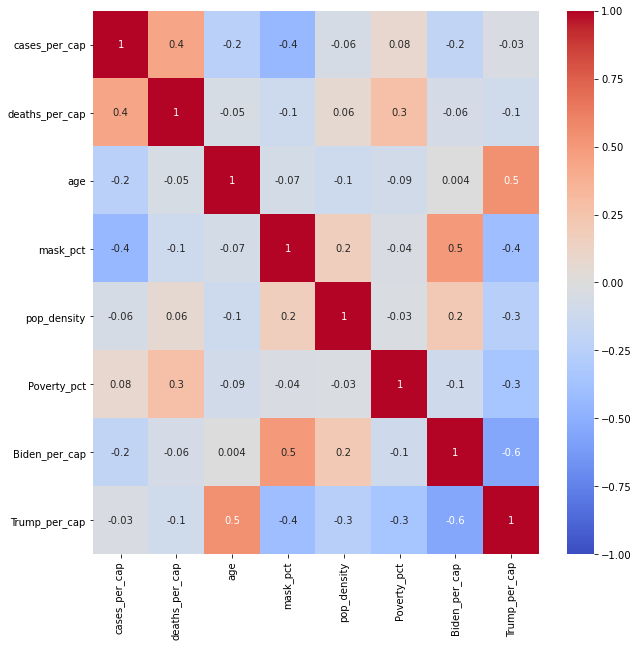

In [10]:
# Print a heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(RDF[['cases_per_cap','deaths_per_cap','age','mask_pct','pop_density','Poverty_pct','Biden_per_cap','Trump_per_cap']].corr(), annot = True, fmt = '0.1g', cmap = 'coolwarm', vmin=-1)

In [11]:
# Create some very macabre fits.
deaths_fit = sm.OLS(RDF['deaths_per_cap'],sm.add_constant(RDF[['Poverty_pct','pop_density','age','mask_pct','Biden_per_cap','Trump_per_cap']])).fit()

print(deaths_fit.summary())

                            OLS Regression Results                            
Dep. Variable:         deaths_per_cap   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     53.38
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           8.04e-63
Time:                        21:43:54   Log-Likelihood:                 17695.
No. Observations:                3043   AIC:                        -3.538e+04
Df Residuals:                    3036   BIC:                        -3.533e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011      0.000      5.766

In [12]:
cases_fit = sm.OLS(RDF['cases_per_cap'],sm.add_constant(RDF[['Poverty_pct','pop_density','age','mask_pct','Biden_per_cap','Trump_per_cap']])).fit()

print(cases_fit.summary())

                            OLS Regression Results                            
Dep. Variable:          cases_per_cap   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     195.6
Date:                Mon, 14 Dec 2020   Prob (F-statistic):          3.11e-211
Time:                        21:43:55   Log-Likelihood:                 7375.4
No. Observations:                3043   AIC:                        -1.474e+04
Df Residuals:                    3036   BIC:                        -1.469e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2004      0.006     34.754

In [13]:
#We will be predicting Florida data, so pull Florida for test
mask = RDF['State'] == 'FL'

RDF_train = RDF[~mask]
RDF_test = RDF[mask]

In [14]:
RDF_train

,Dates,fips,County Name,State,cases,deaths,age,POPESTIMATE2018,Poverty_pct,Biden,Trump,land,COUNTYFP,mask_pct,cases_per_cap,deaths_per_cap,pop_density,Biden_per_cap,Trump_per_cap
322,12/9/2020,1001,Autauga County,AL,3117,42,39.110204,55533,13.8,7503,19838,604.49,1001,0.739,0.056129,0.000756,91.867525,0.135109,0.357229
645,12/9/2020,1003,Baldwin County,AL,10087,141,41.936009,217855,9.8,24578,83544,2027.08,1003,0.759,0.046301,0.000647,107.472325,0.112818,0.383484
968,12/9/2020,1005,Barbour County,AL,1245,30,40.922061,24872,30.9,4816,5622,904.59,1005,0.692,0.050056,0.001206,27.495329,0.193631,0.226037
1291,12/9/2020,1007,Bibb County,AL,1322,39,40.030723,22367,21.8,1986,7525,625.50,1007,0.850,0.059105,0.001744,35.758593,0.088792,0.336433
1614,12/9/2020,1009,Blount County,AL,3496,47,40.258569,57771,13.2,2640,24711,650.65,1009,0.653,0.060515,0.000814,88.789672,0.045698,0.427741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981596,12/9/2020,56037,Sweetwater County,WY,2245,13,36.712467,42858,8.4,3823,12229,10491.73,56037,0.414,0.052382,0.000303,4.084932,0.089202,0.285338
981919,12/9/2020,56039,Teton County,WY,1834,2,40.288442,23269,6.3,9848,4341,4221.96,56039,0.587,0.078817,0.000086,5.511421,0.423224,0.186557
982242,12/9/2020,56041,Uinta County,WY,1250,7,37.127559,20292,10.0,1591,7496,2087.66,56041,0.471,0.061601,0.000345,9.719974,0.078405,0.369407
982565,12/9/2020,56043,Washakie County,WY,586,11,42.326714,7877,11.9,651,3245,2242.85,56043,0.572,0.074394,0.001396,3.512049,0.082646,0.411959


In [15]:
#results for cases and deaths are individual
X_train = RDF_train[['Poverty_pct','pop_density','age','mask_pct','Biden_per_cap','Trump_per_cap']]
y_cases_train = RDF_train['cases_per_cap']
y_deaths_train = RDF_train['deaths_per_cap']

X_test = RDF_test[['Poverty_pct','pop_density','age','mask_pct','Biden_per_cap','Trump_per_cap']]
y_cases_test = RDF_test['cases_per_cap']
y_deaths_test = RDF_test['deaths_per_cap']

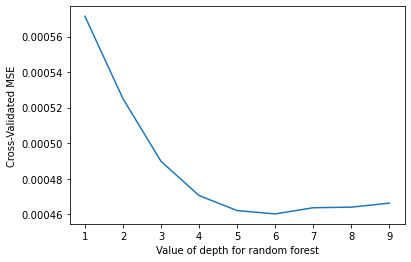

In [16]:
#Cross-validation for cases random forest
d_range = np.arange(1, 10)
d_scores = []
for d in d_range:
    rf = RandomForestRegressor(max_depth = d)
    loss = abs(cross_val_score(rf, X_train, y_cases_train, cv=5, scoring='neg_mean_squared_error'))
    d_scores.append(loss.mean())
    
plt.plot(d_range, d_scores)
plt.xlabel('Value of depth for random forest')
plt.ylabel('Cross-Validated MSE')
plt.show()

In [17]:
print('Smallest error: ' + str(min(d_scores)) + ' at a forest depth of ' + str(d_range[d_scores == min(d_scores)][0]))

Smallest error: 0.0004601928945830641 at a forest depth of 6


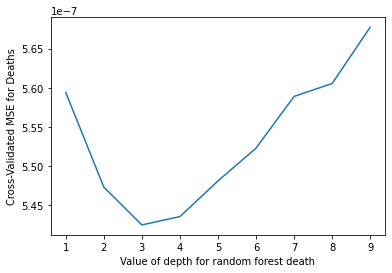

In [18]:
#cross-validation for deaths random forest
dd_scores = []
for d in d_range:
    rf = RandomForestRegressor(max_depth = d)
    loss = abs(cross_val_score(rf, X_train, y_deaths_train, cv=5, scoring='neg_mean_squared_error'))
    dd_scores.append(loss.mean())
    
plt.plot(d_range, dd_scores)
plt.xlabel('Value of depth for random forest death')
plt.ylabel('Cross-Validated MSE for Deaths')
plt.show()

In [19]:
print('Smallest error for deaths: ' + str(min(dd_scores)) + ' at a forest depth of ' + str(d_range[dd_scores == min(dd_scores)][0]))

Smallest error for deaths: 5.425074791209004e-07 at a forest depth of 3


In [20]:
#Fit random forest regressor for cases at max_depth min(d_score)
regr_c = RandomForestRegressor(max_depth = d_range[d_scores == min(d_scores)][0])
regr_c.fit(X_train, y_cases_train)


#Fit random forest regressor for deaths at max_depth min(dd_score)
regr_d = RandomForestRegressor(max_depth = d_range[dd_scores == min(dd_scores)][0])
regr_d.fit(X_train, y_deaths_train)

RandomForestRegressor(max_depth=3)

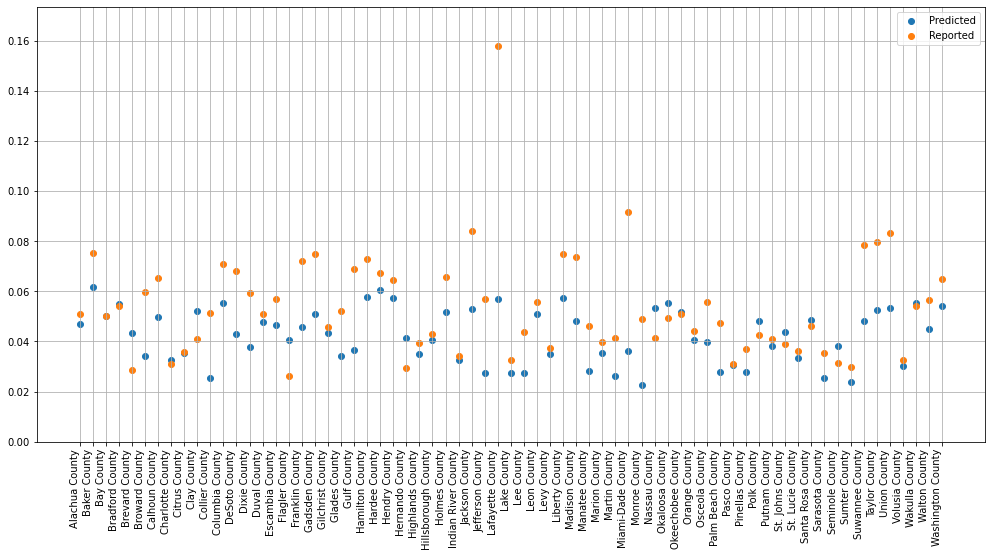

In [23]:
#plot predictions for cases
fix, ax = plt.subplots(1,1, figsize=(17,8))

ax.scatter(RDF_test['County Name'], regr_c.predict(X_test), label = 'Predicted')
ax.scatter(RDF_test['County Name'], y_cases_test, label = 'Reported')
ax.legend()
ax.grid(True)
ax.set_ylim(0,max(y_cases_test)*1.1)
ax.set_xticklabels(RDF_test['County Name'], rotation=90, ha='right');

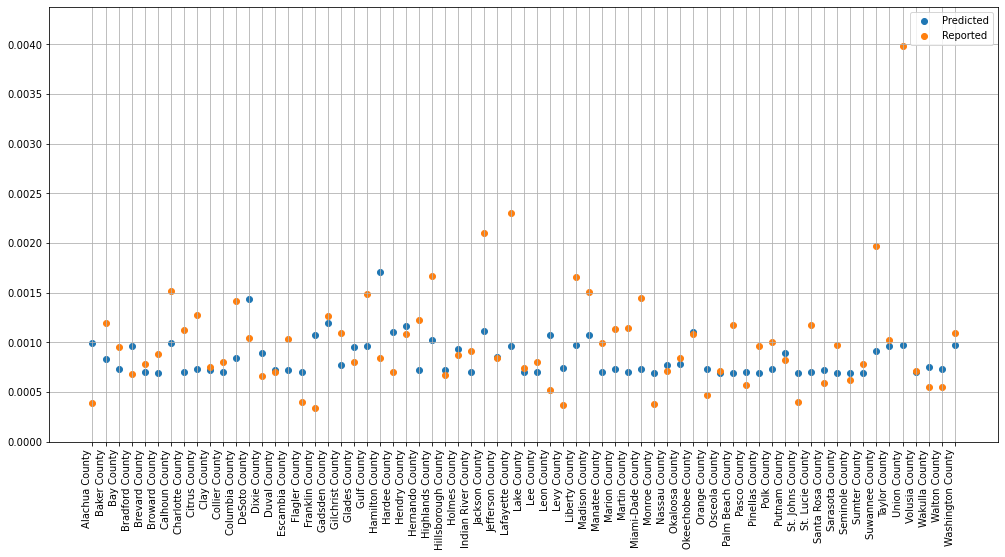

In [24]:
#plot predictions for deaths
fix, ax = plt.subplots(1,1, figsize=(17,8))

ax.scatter(RDF_test['County Name'], regr_d.predict(X_test), label = 'Predicted')
ax.scatter(RDF_test['County Name'], y_deaths_test, label = 'Reported')
ax.legend()
ax.grid(True)
ax.set_ylim(0,max(y_deaths_test)*1.1)
ax.set_xticklabels(RDF_test['County Name'], rotation=90, ha='right');

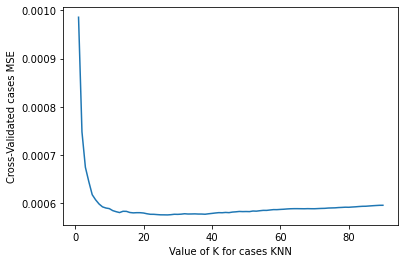

In [25]:
#Cross-validation for cases KNeighbors Regressor
k_range = np.arange(1, 91)
k_scores = []
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    loss = abs(cross_val_score(knn, X_train, y_cases_train, cv=5, scoring='neg_mean_squared_error'))
    k_scores.append(loss.mean())
    
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for cases KNN')
plt.ylabel('Cross-Validated cases MSE')
plt.show()

In [26]:
print('Smallest error: ' + str(min(k_scores)) + ' at ' + str(k_range[k_scores == min(k_scores)][0]) + ' nearest neighbors.')

Smallest error: 0.0005754843504784845 at 27 nearest neighbors.


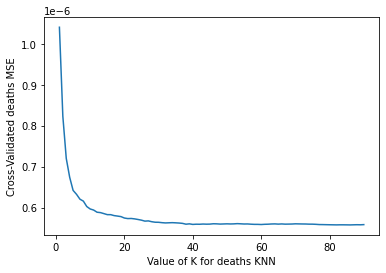

In [27]:
#Cross-validation for deaths KNeighbors Regressor
dk_scores = []
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    loss = abs(cross_val_score(knn, X_train, y_deaths_train, cv=5, scoring='neg_mean_squared_error'))
    dk_scores.append(loss.mean())
    
plt.plot(k_range, dk_scores)
plt.xlabel('Value of K for deaths KNN')
plt.ylabel('Cross-Validated deaths MSE')
plt.show()

In [28]:
print('Smallest error for deaths: ' + str(min(dk_scores)) + ' at ' + str(k_range[dk_scores == min(dk_scores)][0]) + ' nearest neighbors.')

Smallest error for deaths: 5.575476021405113e-07 at 86 nearest neighbors.


In [29]:
#Fit KNeighbors Regressor for Cases and Deaths
knn_c = KNeighborsRegressor(n_neighbors=k_range[k_scores == min(k_scores)][0])
knn_d = KNeighborsRegressor(n_neighbors=k_range[dk_scores == min(dk_scores)][0])

knn_c.fit(X_train, y_cases_train)
knn_d.fit(X_train, y_deaths_train)

KNeighborsRegressor(n_neighbors=86)

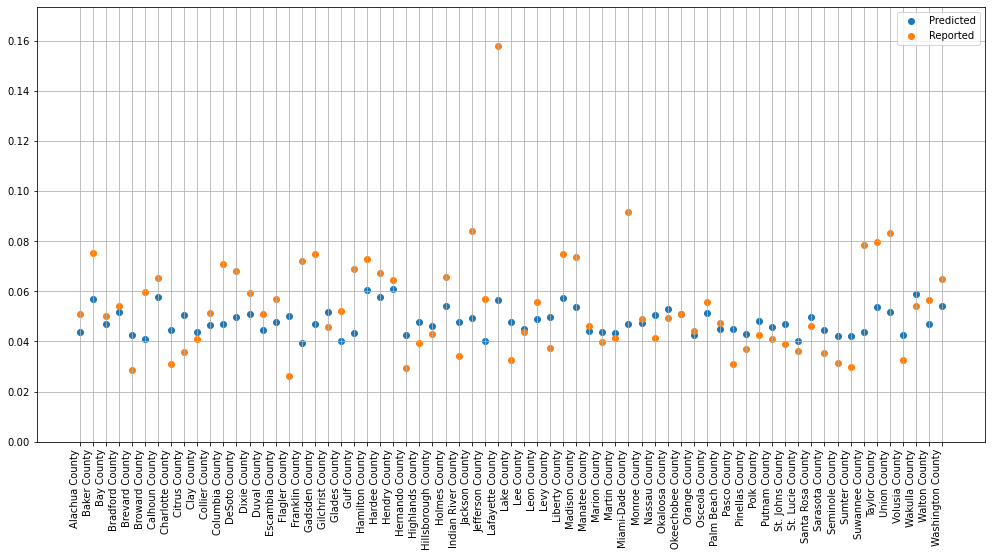

In [30]:
fix, ax = plt.subplots(1,1, figsize=(17,8))

ax.scatter(RDF_test['County Name'], knn_c.predict(X_test), label = 'Predicted')
ax.scatter(RDF_test['County Name'], y_cases_test, label = 'Reported')
ax.legend()
ax.grid(True)
ax.set_ylim(0,max(y_cases_test)*1.1)
ax.set_xticklabels(RDF_test['County Name'], rotation=90, ha='right');

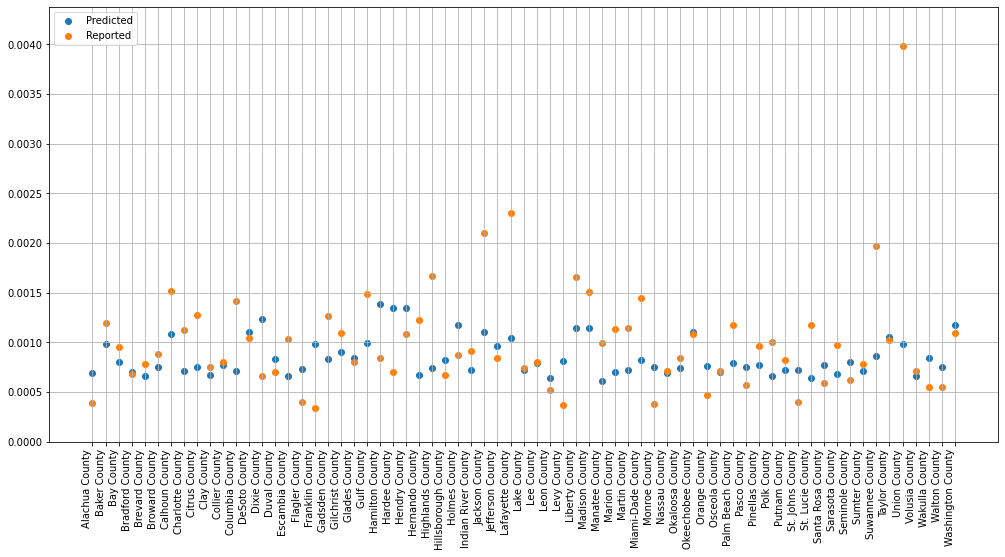

In [31]:
fix, ax = plt.subplots(1,1, figsize=(17,8))

ax.scatter(RDF_test['County Name'], knn_d.predict(X_test), label = 'Predicted')
ax.scatter(RDF_test['County Name'], y_deaths_test, label = 'Reported')
ax.legend(loc = 'upper left')
ax.grid(True)
ax.set_ylim(0,max(y_deaths_test)*1.1)
ax.set_xticklabels(RDF_test['County Name'], rotation=90, ha='right');